In [1]:
%run ../utils.py
%run models.py

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import os.path as osp
import pickle
import matplotlib.pyplot as plt
from cvutils import visualize
from imgaug import augmenters as iaa
import imgaug as ia
from cvutils.keras import generator as keras_generator
from cvutils.augmentation import imgaug as imgaug_utils
from codex_ml import losses
from codex_ml import augmentation as augmentation_pipelines
import pandas as pd
seed = 8932
plt.gray()
init_session()

train_image_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'stage1_train')
data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'prep')
data_file = 'training_data_03.pkl' # crop resizing, shrunken markers
model_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.1')
model_path = osp.join(model_dir, 'nuclei_model.h5')

In [3]:
with open(osp.join(data_dir, data_file), 'rb') as fd:
    data = pickle.load(fd)

In [4]:
data.keys()

dict_keys(['meta', 'class_names', 'Y', 'X', 'index'])

In [5]:
X, Y, class_names, index, meta = [data[k] for k in ['X', 'Y', 'class_names', 'index', 'meta']]

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype, index.shape

((1752, 256, 256, 1),
 dtype('uint8'),
 (1752, 256, 256, 5),
 dtype('bool'),
 (1752,))

In [7]:
input_shape = X.shape[1:]
input_shape

(256, 256, 1)

In [8]:
class_names

['bg', 'nuc_interior', 'nuc_boundary', 'nuc_partition', 'nuc_center']

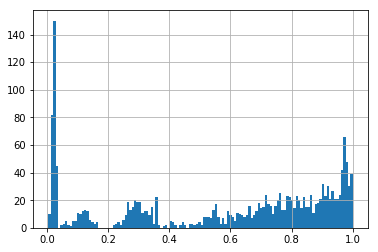

In [9]:
# Determine percent coverage of background in each image
bg_pcts = pd.Series([Y[i, ..., class_names.index('bg')].mean() for i in range(Y.shape[0])])
bg_pcts.hist(bins=128)

In [10]:
bg_mask = ((bg_pcts > .5) & (bg_pcts < 1.)).values
X, Y, index = X[bg_mask], Y[bg_mask], index[bg_mask]
X.shape, Y.shape, index.shape

((1091, 256, 256, 1), (1091, 256, 256, 5), (1091,))

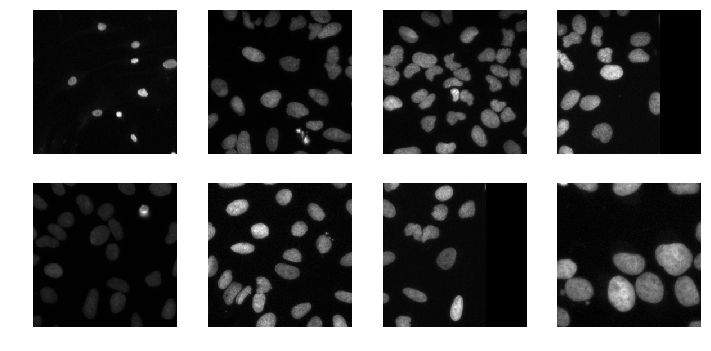

In [11]:
visualize.display_images([X[i, ..., 0] for i in range(0, 8)], size=12)

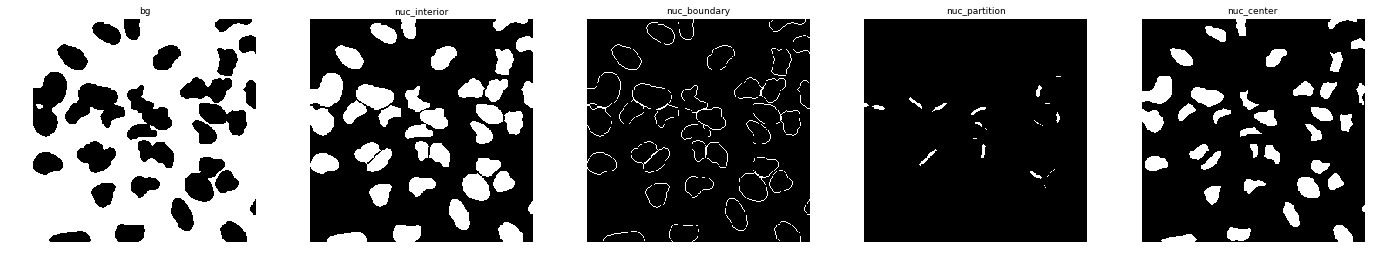

In [12]:
visualize.display_images([Y[2, ..., i] for i in range(Y.shape[-1])], cols=len(class_names), titles=class_names, size=24)

In [13]:
# Determine frequency of positive pixels by mask class
class_freq = np.apply_over_axes(np.mean, Y, axes=[0, 1, 2]).squeeze()
class_freq = pd.Series(dict(zip(class_names, class_freq)))
class_freq

bg               0.816516
nuc_boundary     0.018195
nuc_center       0.071726
nuc_interior     0.118800
nuc_partition    0.002741
dtype: float64

In [14]:
1/class_freq

bg                 1.224715
nuc_boundary      54.960932
nuc_center        13.941878
nuc_interior       8.417475
nuc_partition    364.815250
dtype: float64

In [68]:
# train_classes = ['nuc_interior', 'nuc_boundary', 'nuc_partition', 'nuc_center']
# train_class_wt = [1., 10., 50., 50.]
train_classes = ['nuc_interior', 'nuc_partition', 'nuc_center']

train_class_wt = [1., 30., 5.]

# pos_importance_factor = 50.
# train_class_wt = 1. / class_freq.loc[train_classes]
# train_class_wt /= train_class_wt.sum()
# train_class_wt = (pos_importance_factor * train_class_wt).round(2).tolist()

train_classes_idx = [class_names.index(c) for c in train_classes]
batch_size = 32

assert len(train_class_wt) == len(train_classes)
n_classes = len(train_classes)
Y_target = Y[..., train_classes_idx]
Y.shape, Y_target.shape, train_class_wt

((1091, 256, 256, 5), (1091, 256, 256, 3), [1.0, 30.0, 5.0])

In [147]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(np.arange(X.shape[0]), test_size=.2, random_state=seed)
X_train, X_test, Y_train, Y_test = X[idx_train], X[idx_test], Y_target[idx_train], Y_target[idx_test]

# X_train = X_train[:(batch_size * 8)]
# Y_train = Y_train[:(batch_size * 8)]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((872, 256, 256, 1),
 (219, 256, 256, 1),
 (872, 256, 256, 3),
 (219, 256, 256, 3))

In [148]:
X_train_moments = dict(mean=X_train.mean(), std=X_train.std())
X_train_moments

{'mean': 22.95665170512068, 'std': 39.01833230843019}

In [149]:
%run models.py
opt_conv = {"activation": "elu", "padding": "same", 'kernel_initializer': 'he_normal'}
#model = get_model(n_classes, input_shape, activation='sigmoid', p=[6,7,8,9], batch_norm=True, dropout=None)

model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None, opt_conv=opt_conv)

#model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None)
#model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=False, dropout=[.1,.1,.2,.2,.3])
#model = get_model(n_classes, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=False, dropout=[.1,.1,.2,.2,.3])

#model = get_model(n_classes, input_shape, activation='sigmoid', p=[6,7,8,9], batch_norm=True, dropout=None)

In [150]:
optimizer = keras.optimizers.RMSprop(lr=1e-3)
metrics = [keras.metrics.binary_accuracy]
loss = losses.objective_weighted_binary_crossentropy([[train_class_wt]])

for i, c in enumerate(train_classes):
    metrics.append(binary_channel_precision(i, c, min_p=.6))
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [151]:
import imp
imp.reload(augmentation_pipelines)
augmentation = augmentation_pipelines.get_augmentation_pipeline_01()

In [152]:
# visualize_augmentation(list(load_images(train_image_dir).values())[0], augmentation, 11, cols=4, size=20)

In [153]:
imp.reload(imgaug_utils)

<module 'cvutils.augmentation.imgaug' from '/lab/repos/cvutils/python/cvutils/augmentation/imgaug.py'>

In [154]:
def pre_network_processor(sample_id, X, Y):
    # Convert image to standardized floats for network
    assert X.dtype == np.uint8
    assert Y.dtype == np.bool
    
    X = X.astype(np.float32)
    X = (X - X_train_moments['mean']) / X_train_moments['std']
    Y = Y.astype(np.float32)
    return X, Y

train_loader = imgaug_utils.InMemoryDataLoader(X_train, Y_train, augmentation=augmentation, processor=pre_network_processor)
test_loader = imgaug_utils.InMemoryDataLoader(X_test, Y_test, augmentation=None, processor=pre_network_processor)

train_generator = keras_generator.BaseDataGenerator(train_loader.ids, train_loader.load, batch_size=batch_size, shuffle=True)
test_generator = keras_generator.BaseDataGenerator(test_loader.ids, test_loader.load, batch_size=batch_size, shuffle=True)

In [155]:
# ex_aug = 'ex2'
# visualize_segmentation_augmentation(
#     X[index == DEFAULT_IDS[ex_aug]][0],
#     Y_target[index == DEFAULT_IDS[ex_aug]][0],
#     augmentation, n=5, size=30
# )

In [ ]:
!rm $model_dir/* || true

callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss', mode='min', verbose=0, 
        save_best_only=True, save_weights_only=False, period=1
    ), 
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='min'), 
    keras.callbacks.TensorBoard(log_dir=model_dir),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, mode='min')
]

history = model.fit_generator(
    train_generator, 
    epochs=75,
    #steps_per_epoch=15,
    callbacks=callbacks,
    validation_data=test_generator
)

Epoch 1/75
27/27 [==============================] - 11s 404ms/step - loss: 0.7462 - binary_accuracy: 0.7604 - nuc_interior: 0.6076 - nuc_partition: 0.0645 - nuc_center: 0.4154 - val_loss: 0.5782 - val_binary_accuracy: 0.9027 - val_nuc_interior: 0.8151 - val_nuc_partition: 0.0141 - val_nuc_center: 0.5529
Epoch 2/75
27/27 [==============================] - 7s 277ms/step - loss: 0.6487 - binary_accuracy: 0.8598 - nuc_interior: 0.7796 - nuc_partition: 0.0823 - nuc_center: 0.5526 - val_loss: 0.5644 - val_binary_accuracy: 0.9230 - val_nuc_interior: 0.9382 - val_nuc_partition: 0.0147 - val_nuc_center: 0.6986
Epoch 3/75
27/27 [==============================] - 9s 319ms/step - loss: 0.6012 - binary_accuracy: 0.8924 - nuc_interior: 0.8301 - nuc_partition: 0.1234 - nuc_center: 0.6175 - val_loss: 0.4753 - val_binary_accuracy: 0.9533 - val_nuc_interior: 0.9243 - val_nuc_partition: 0.0180 - val_nuc_center: 0.7057
Epoch 4/75
27/27 [==============================] - 9s 348ms/step - loss: 0.5600 - bina

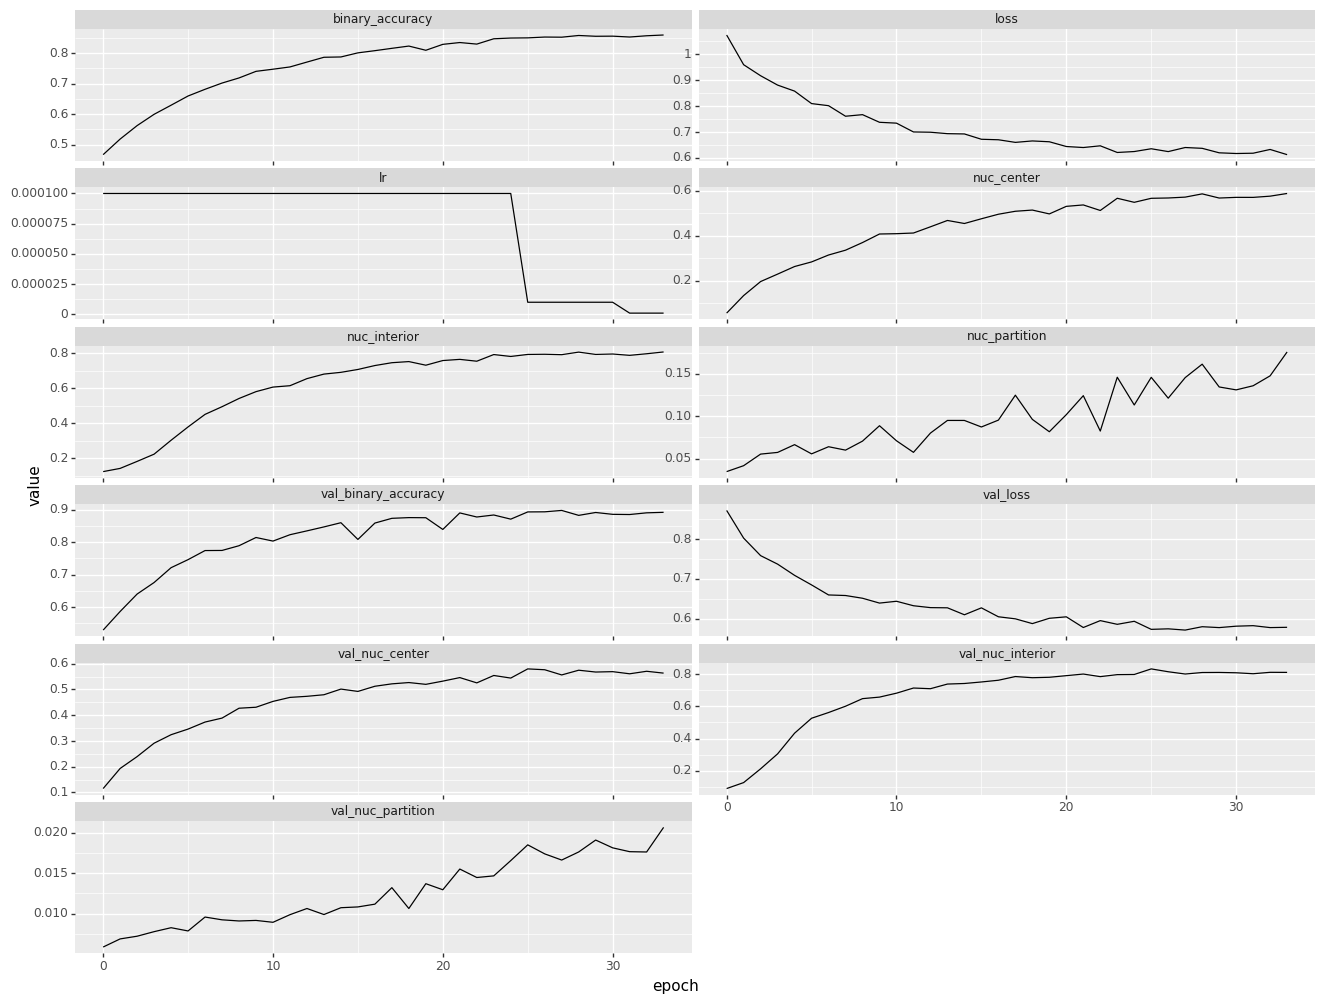

<ggplot: (8731985817064)>

In [121]:
plot_model_history(history.history, window=slice(None, None))

In [139]:
pred_model = model

In [141]:
def inference_data(ids):
    mask = np.in1d(index, ids)
    Xi, Yi = X[mask], Y_target[mask]
    loader = imgaug_utils.InMemoryDataLoader(Xi, Yi, augmentation=None, processor=pre_network_processor)
    gen = keras_generator.BaseDataGenerator(loader.ids, loader.load, batch_size=len(Xi), shuffle=True)
    return gen[0]

inf_ids = [
    'a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288',
    '0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1',
    '07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5',
    '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
    '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3',
    '8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842',
    '547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6',
    'c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932',
    'cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490',
    '6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622'
]
X_pred, Y_true = inference_data(inf_ids)
X_pred.shape, Y_true.shape

((63, 256, 256, 1), (63, 256, 256, 3))

In [130]:
#pred_batch = train_batches
X_pred, Y_true = test_generator[1]
#X_pred, Y_true = train_generator[0]

In [142]:
Y_pred = pred_model.predict(X_pred)

In [143]:
X_pred.shape, Y_pred.shape, Y_true.shape

((63, 256, 256, 1), (63, 256, 256, 3), (63, 256, 256, 3))

In [144]:
X_pred.min(), X_pred.max()

(-0.5979446, 6.023343)

In [145]:
Y_pred.min(), Y_pred.max()

(0.26900244, 0.99990404)

In [127]:
# plt.hist(Y_pred.ravel(), bins=248)
# ax = plt.gca()
# ax.set_yscale('symlog')
# None

In [134]:
train_classes

['nuc_interior', 'nuc_partition', 'nuc_center']

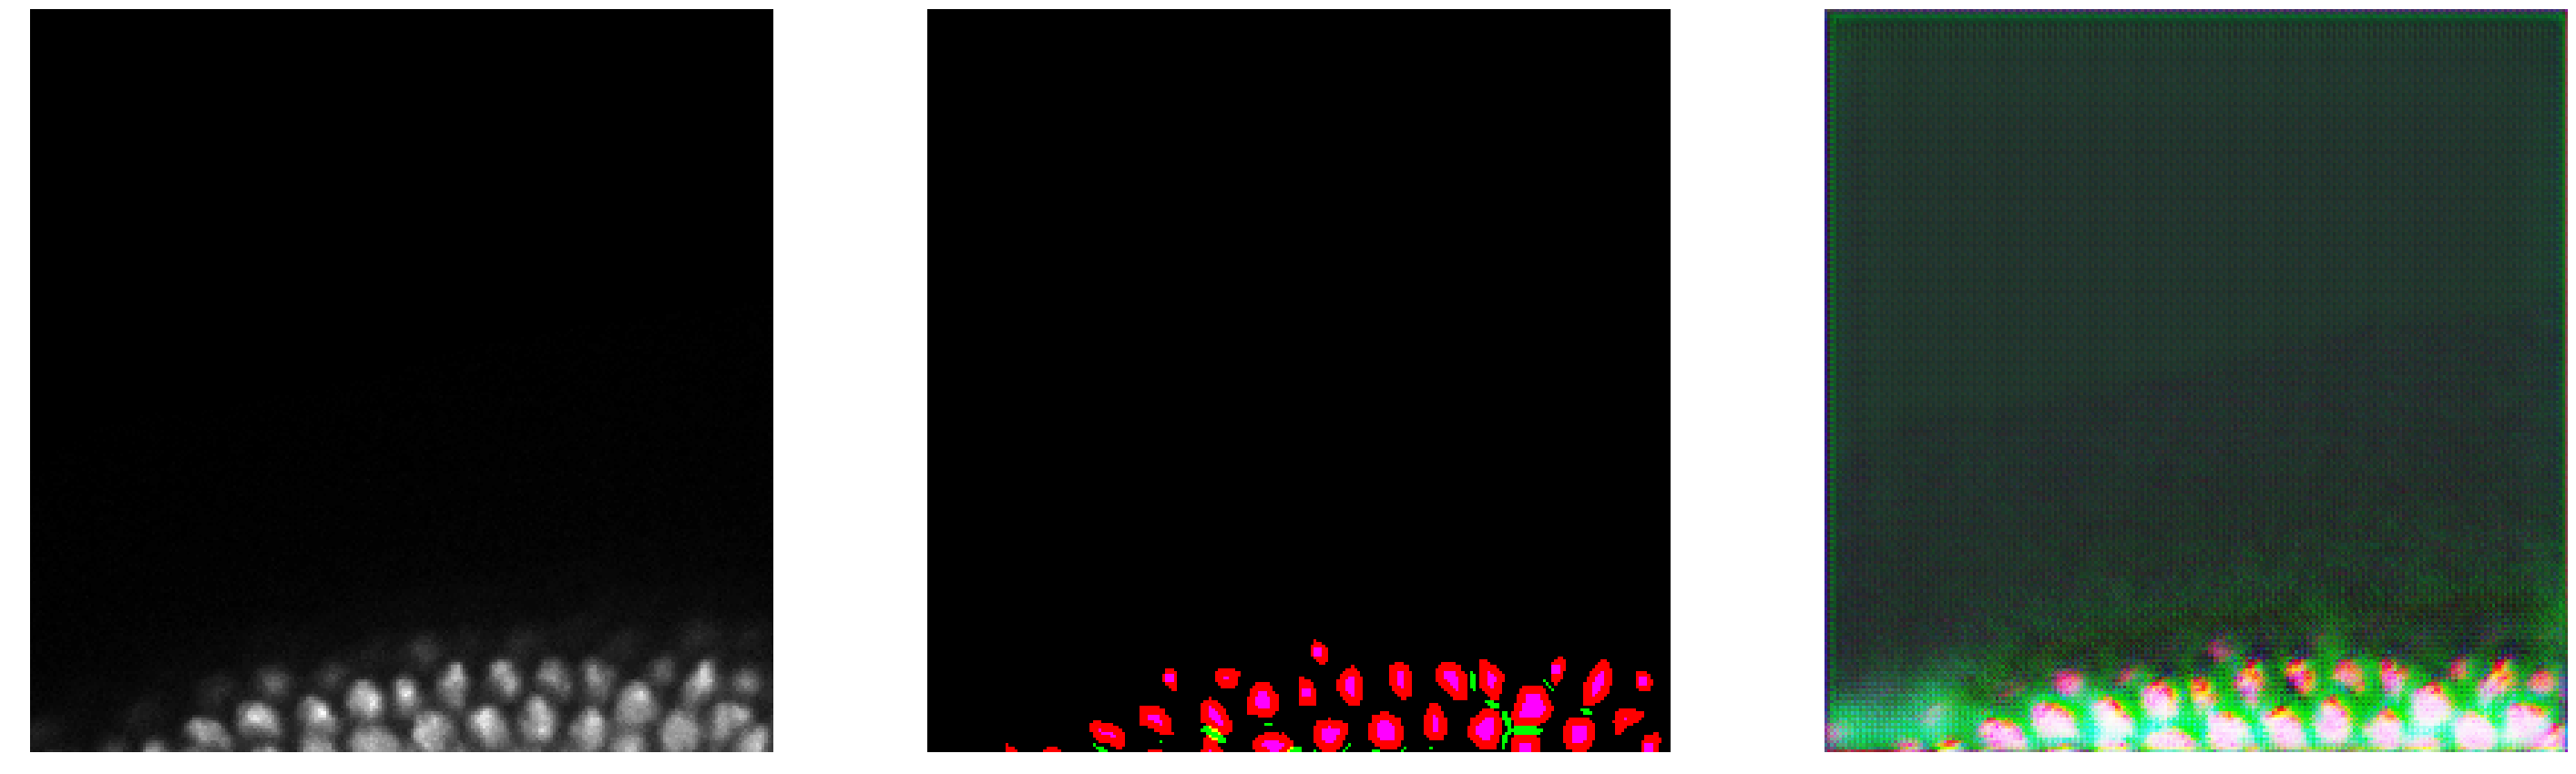

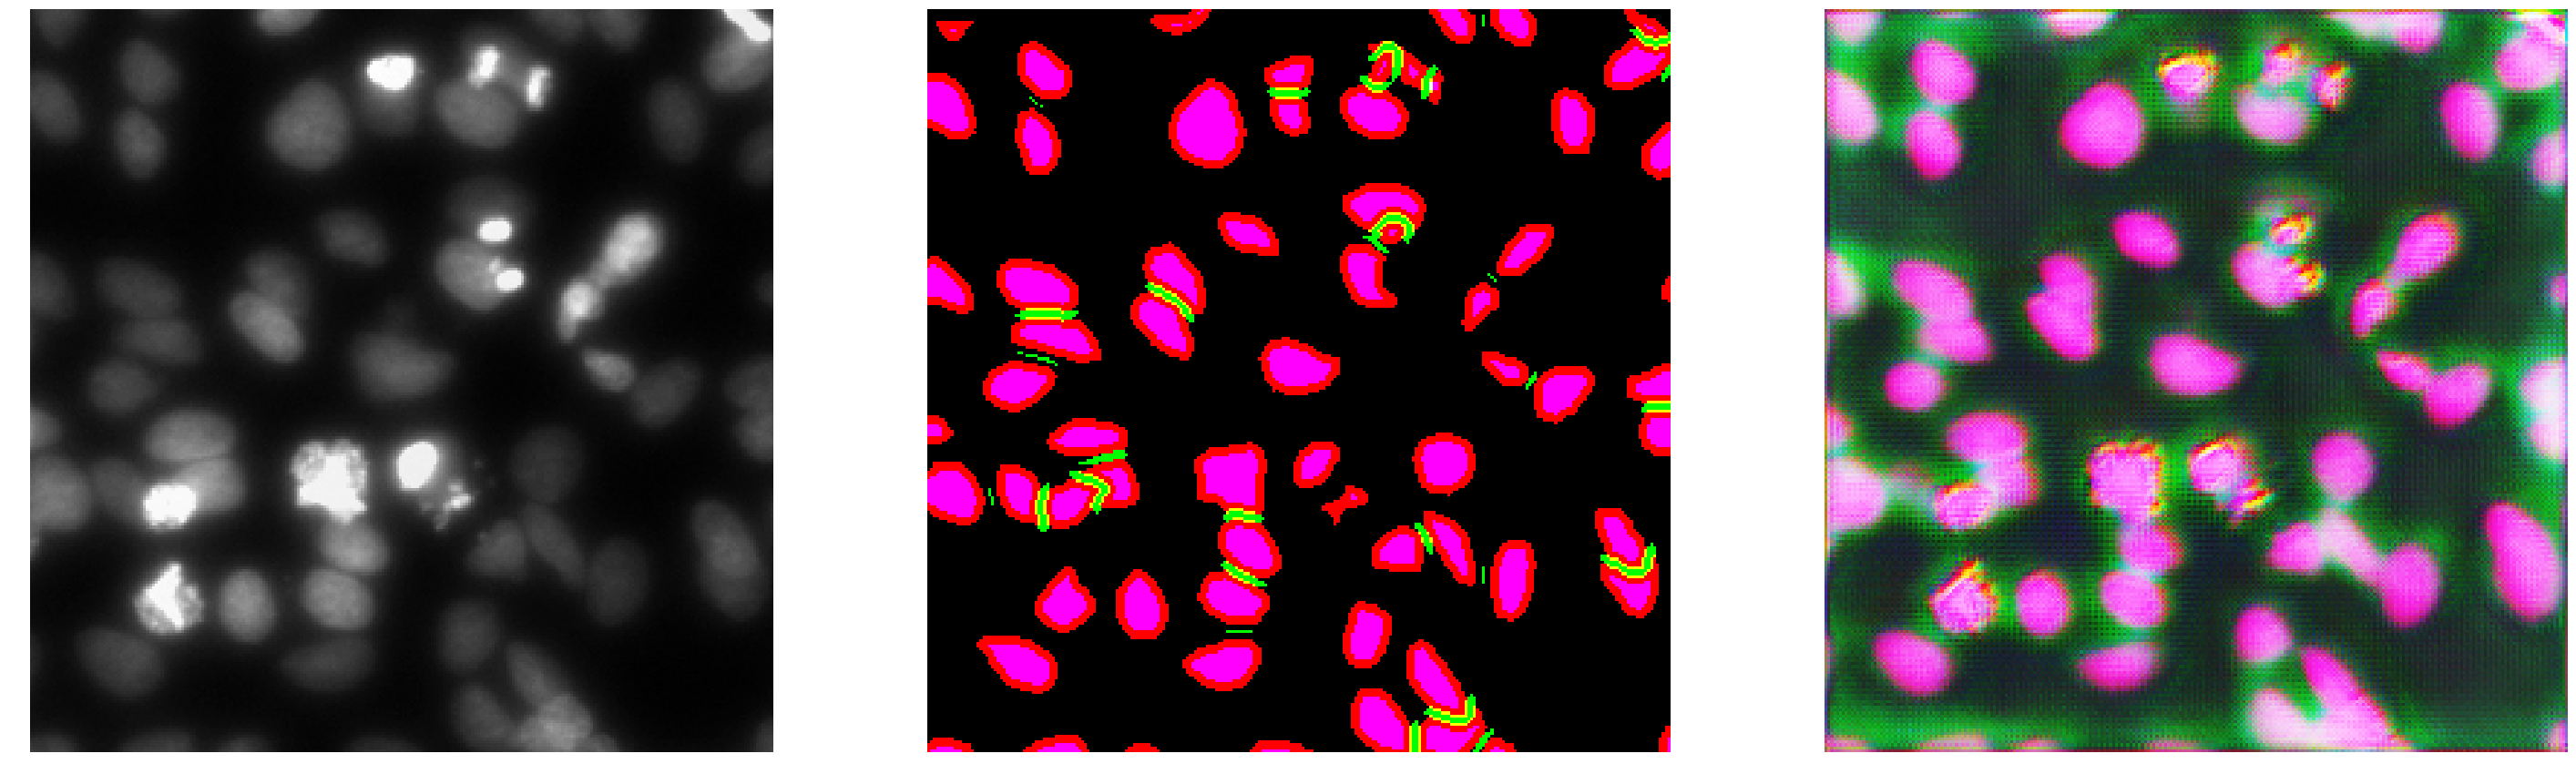

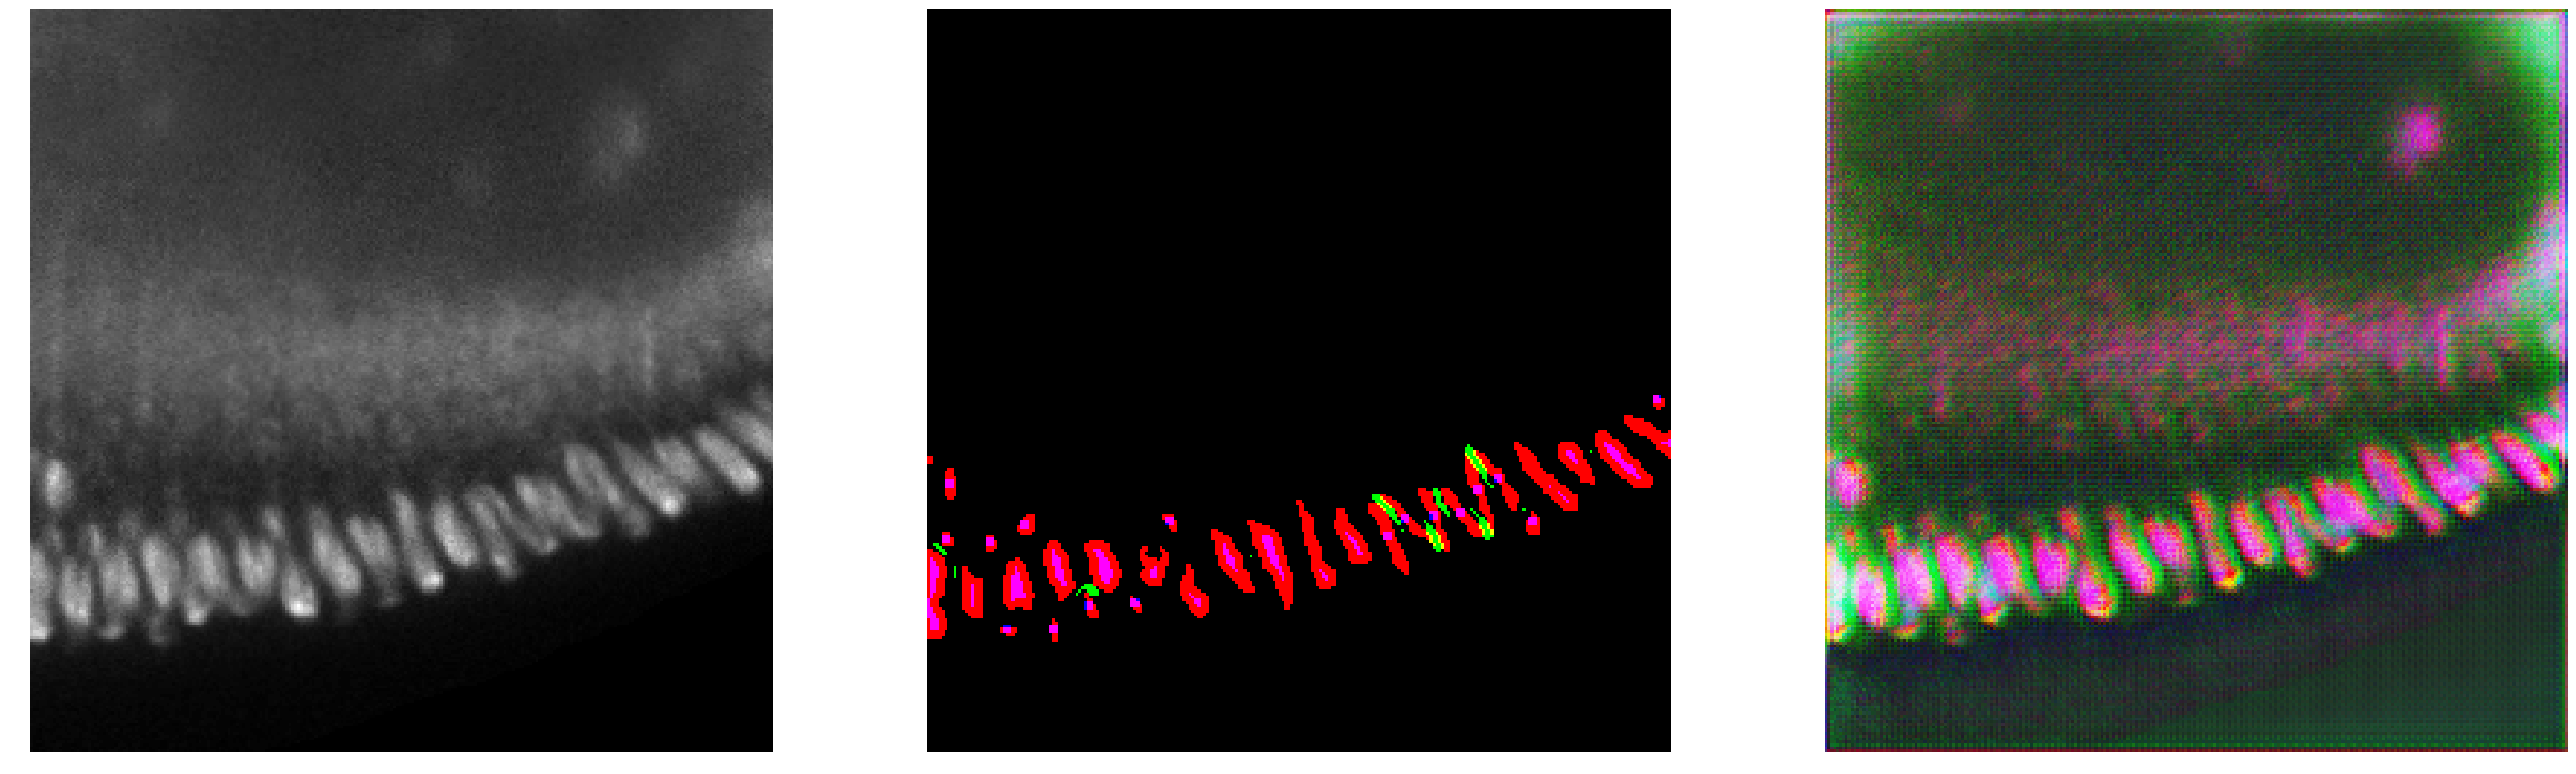

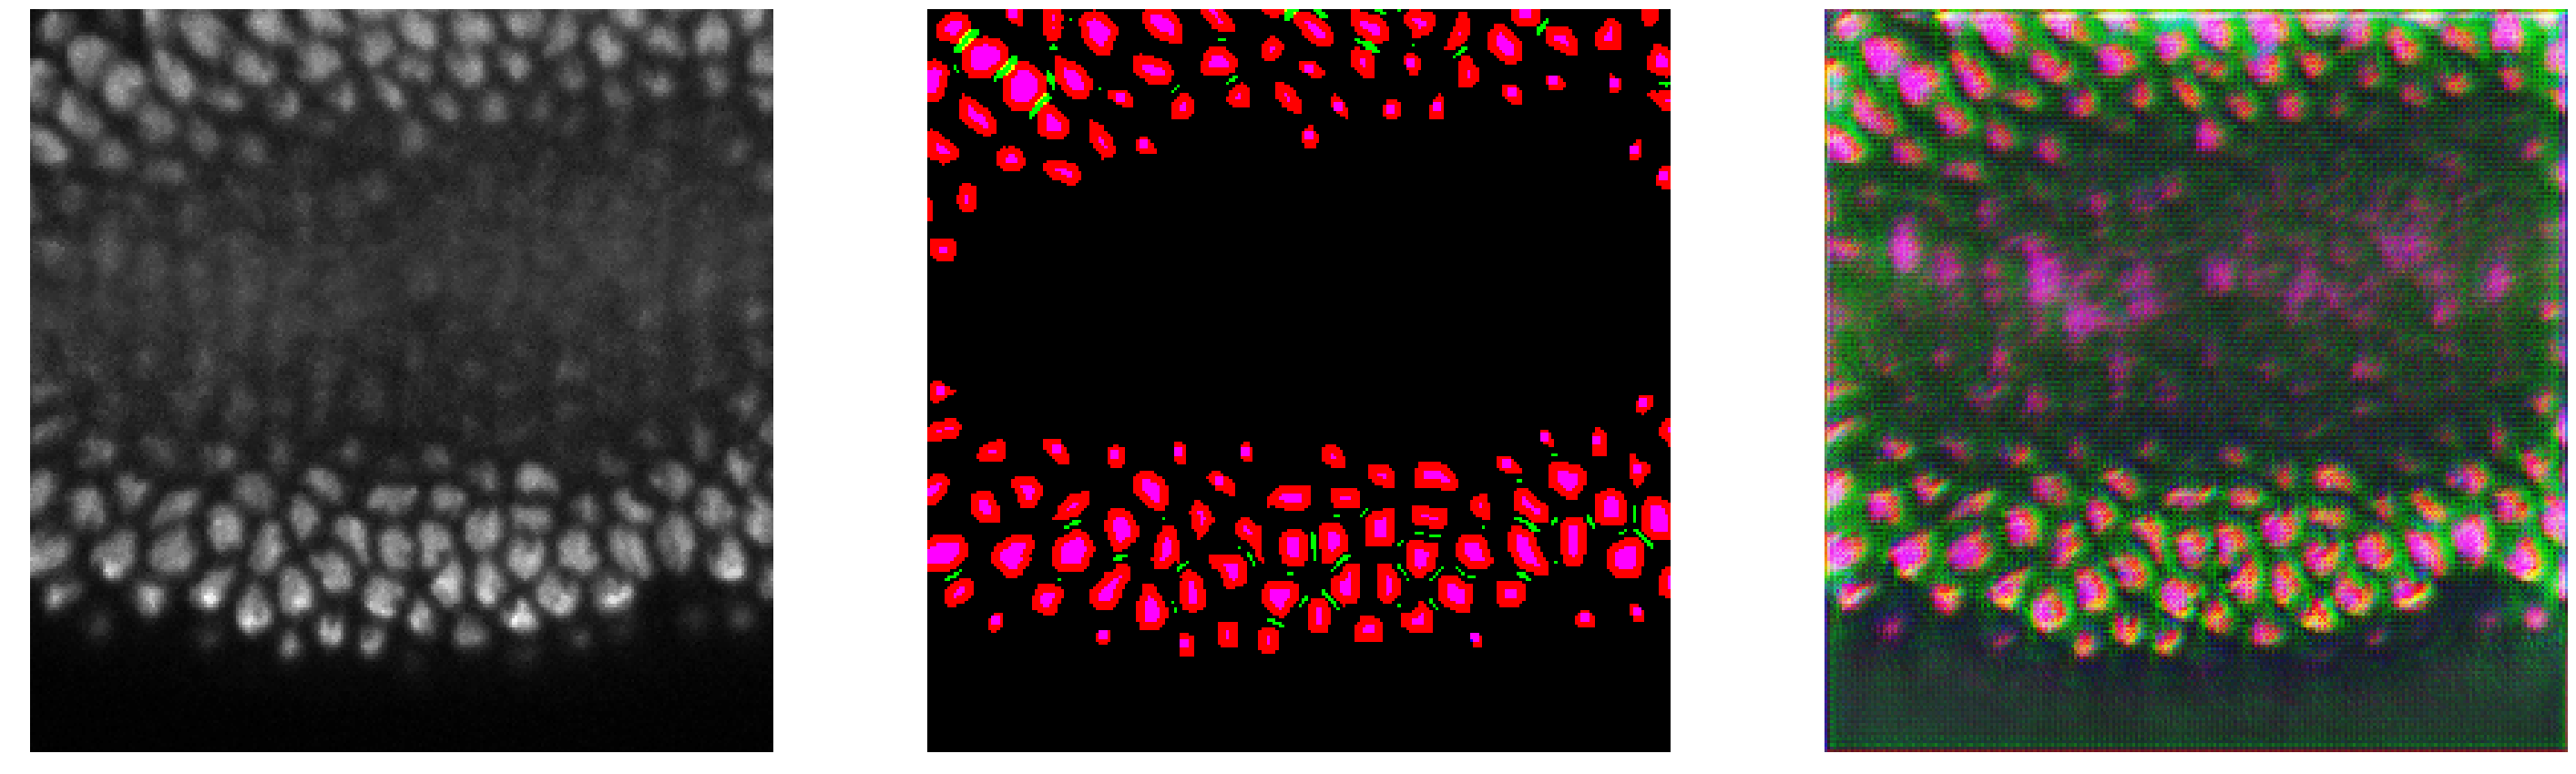

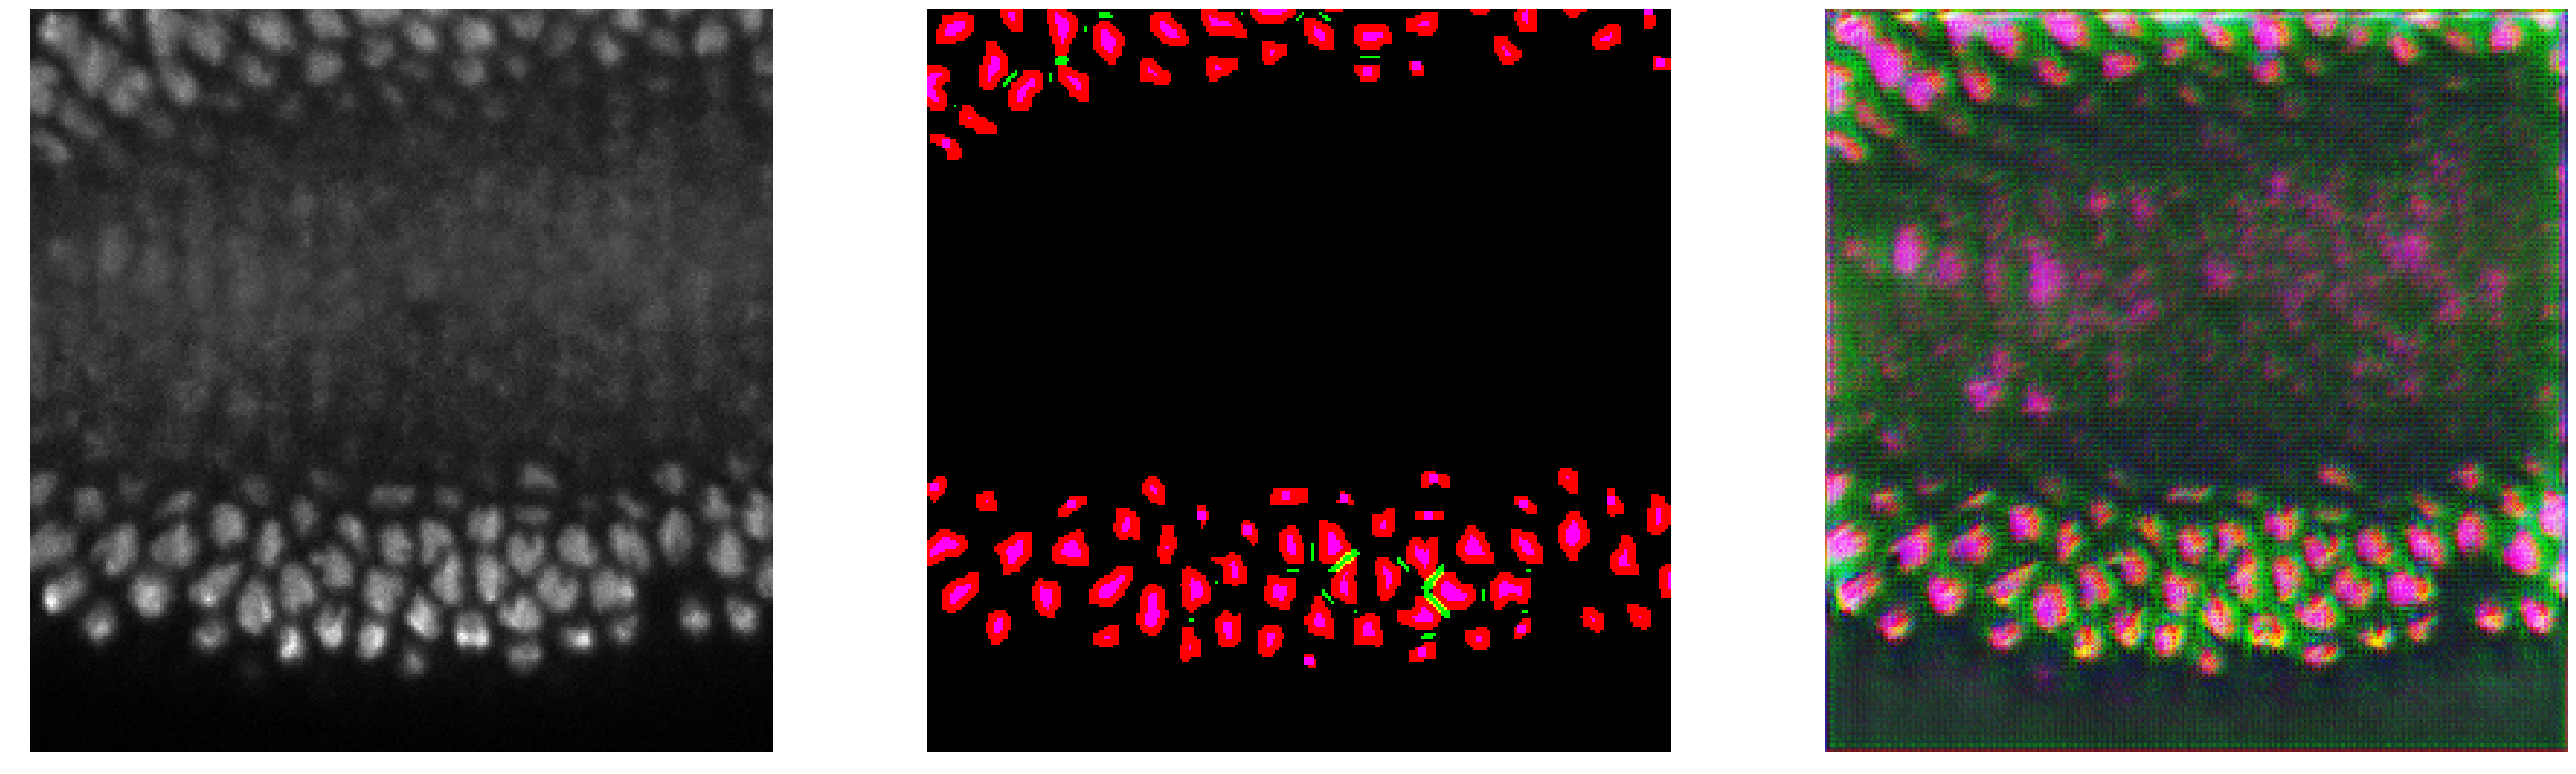

In [146]:
from skimage import exposure
y_chs = [0, 1, 2]
assert len(y_chs) == 3
viz_idx = np.random.choice(np.arange(len(X_pred)), replace=False, size=min(5, len(X_pred)))
#viz_idx = [0, 1, 2, 3, 4, 5]
#viz_idx = [0, 1, 2]
for i in viz_idx:
    images = []
    images += [exposure.rescale_intensity(X_pred[i, ..., 0], out_range=np.uint8).astype(np.uint8)]
    images += [exposure.rescale_intensity(Y_true[i][..., y_chs], out_range=np.uint8).astype(np.uint8)]
    images += [np.stack([
        exposure.rescale_intensity(Y_pred[i][..., yi], out_range=np.uint8).astype(np.uint8)
        for yi in y_chs
    ], -1)]
    visualize.display_images(images, size=50, cols=3)

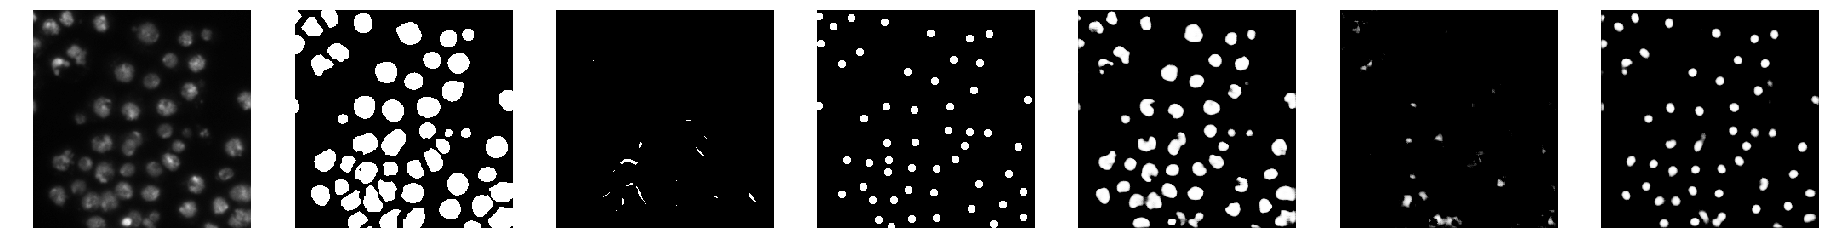

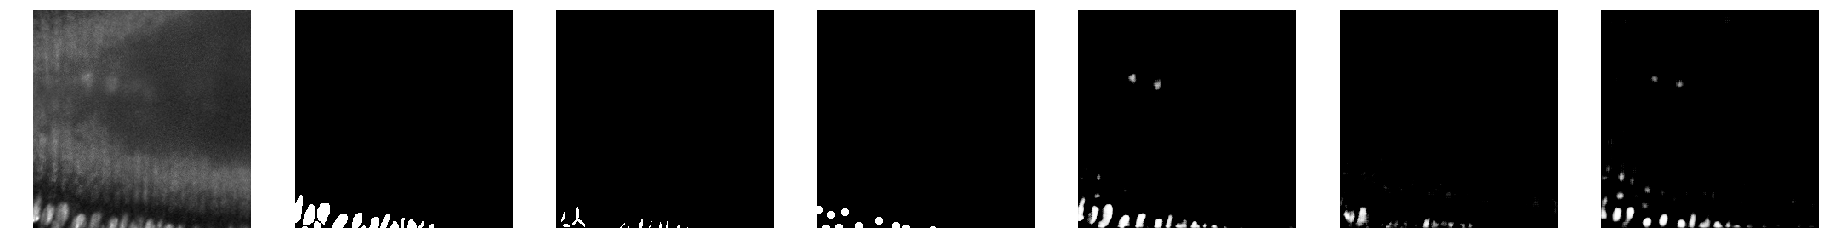

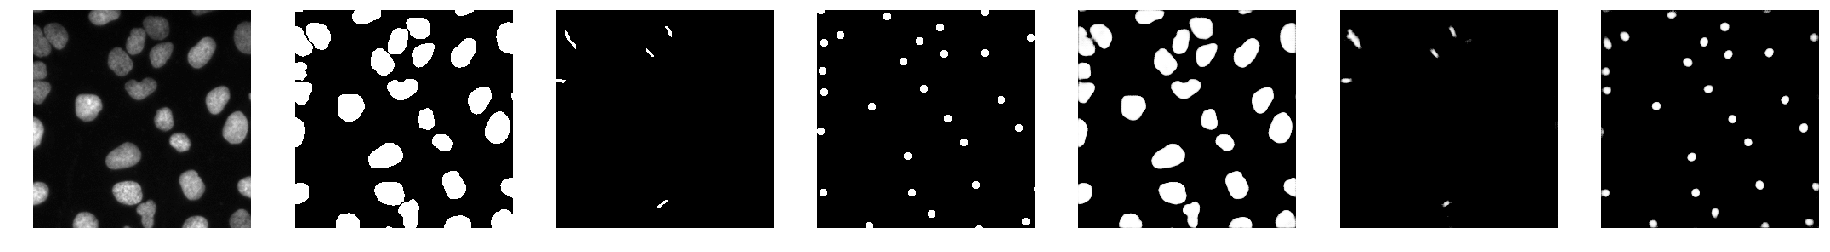

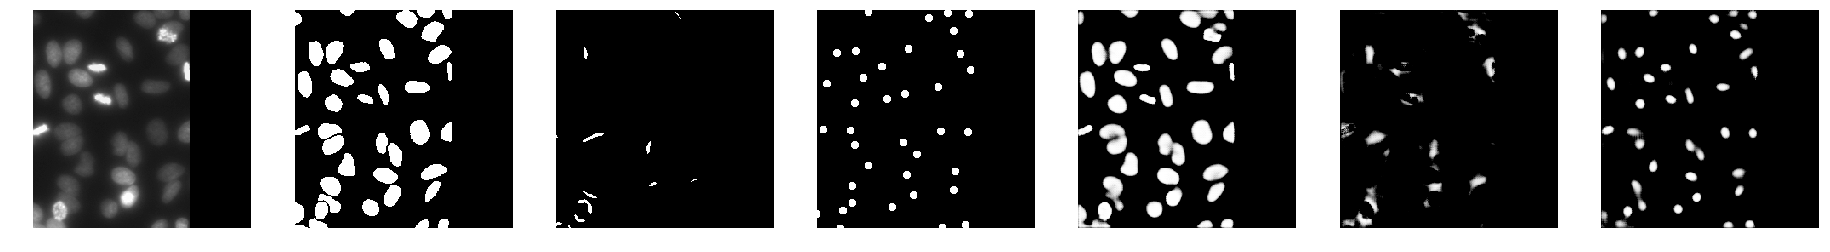

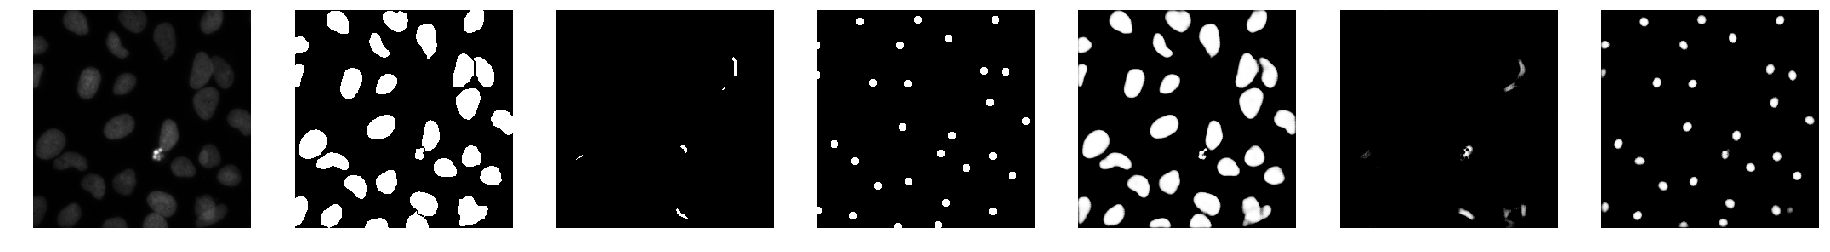

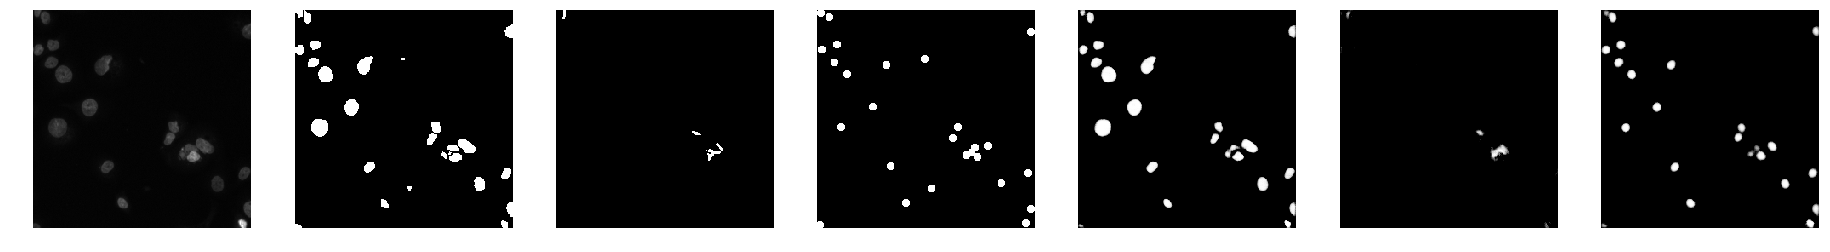

In [104]:
y_chs = [0, 1, 2]
for i in [0, 1, 2, 3, 4, 5]:
    images = []
    images += [X_pred[i, ..., 0]]
    images += [Y_true[i, ..., ch] for ch in y_chs]
    images += [Y_pred[i, ..., ch] for ch in y_chs]
    visualize.display_images(images, size=32, cols=2*len(y_chs)+1)